# Imports

In [1]:
# Python standard library
import sys
import csv

# Scientific computing
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy.ndimage

# Program specific
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/rp/')
sys.path.append('/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/')
import resistive_pulse as rp
import rp_file
import optical_imaging as oi
import oi_file


# Jupyter
from IPython.display import HTML

# Load data

In [2]:
date = '7-17-2017/'
particle = '293-T/'
channel = '15-30-15_6/'
file_index = '0'

base_path = '/home/prestonh/Desktop/Research/cancer_cells/data/'

oi_vid_file_path = base_path + date + particle + channel + 'oi/bin/test_camera_' + file_index
oi_events_file_path = base_path + date + particle + channel + 'oi/events/test_camera_' + file_index + '_events.json'

In [3]:
# Load video
oi_vid = oi_file.Video(oi_vid_file_path, 512, 288, 100000)

# Load events
oi_events = oi_file.open_event_file_json(oi_events_file_path)

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:63: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if pixels != None:


# Load template and create stage

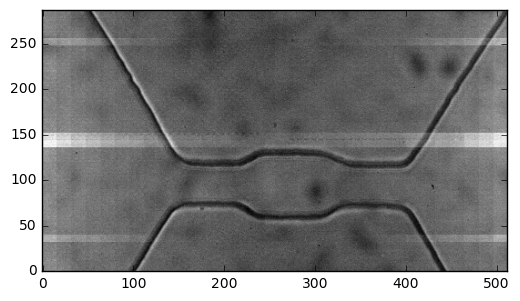

In [4]:
template_index = 0

template_frame = oi_vid.get_frame(template_index)

plt.imshow(template_frame, cmap = 'gray', origin = 'lower')
plt.show()

[ 0.01224398  0.99992504]


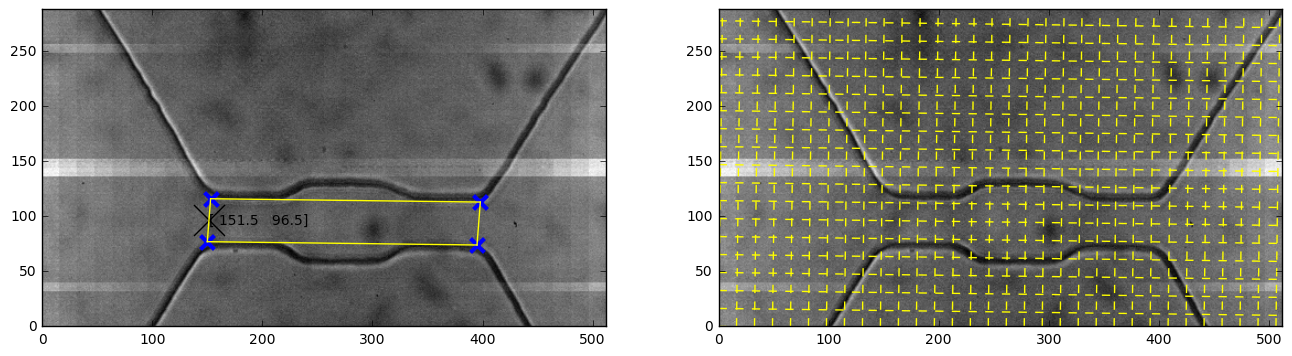

In [5]:
reload(oi)
template_index = 0
template_frame = oi_vid.get_frame(template_index)
c0 = [153,116]
c1 = [150,77]
c2 = [395,74]
c3 = [398,113]
oi_stage = oi.Stage(template_frame, c0, c1, c2, c3)
oi_stage.plot_stage()

# Define plotting functions

In [6]:
def plot_frame(frame, show = True):
    plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
    
    if show:
        plt.show()
    
def plot_processed_over_raw(processed_frame, frame, show = True):
    green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
    green_processed_frame[:,:,1] = processed_frame

    plt.imshow(frame, cmap = 'gray', origin = 'lower', alpha = 1, interpolation = 'none')
    plt.imshow(green_processed_frame, cmap = 'gray', origin = 'lower', alpha = 0.15, interpolation = 'none')

    if show:
        plt.show()
    
def plot_frame_hist(frame, show = True):
    plt.hist(frame.flatten(), facecolor = 'k', bins = 100)
    
    if show:
        plt.show()
    
def plot_all(processed_frame, frame):
    fig, axes = plt.subplots(1,3,figsize = (12,3))
    
    # Plot 1
    plt.sca(axes[0])
    plot_frame(processed_frame, show = False)
    
    
    # Plot 2
    plt.sca(axes[1])
    plot_processed_over_raw(processed_frame, frame, show = False)
    
    # Plot 3
    plt.sca(axes[2])
    plot_frame_hist(processed_frame, show = False)
    
    plt.show()

# Define ellipse fitting functions

In [7]:
def crop_frame(frame, px, py, crop_distance):    
    x0 = int(px - crop_distance)
    x1 = int(px + crop_distance)
    y0 = int(py - crop_distance)
    y1 = int(py + crop_distance)
    cropped_frame = np.copy(frame)[y0:y1, x0:x1]
    
    return cropped_frame
    

    
    
    
    
    

preprocessing_steps = []
def preprocess_frame(frame, template_frame, detection, debug = 'none'):

    # Refresh list
    del preprocessing_steps[:]

    

    #################################
    # Copy
    #################################
    
    
    
    preprocessing_steps.append(['copy'])

    processed_frame = np.copy(frame)

    if debug == 'all':
        print 'copy'
        plot_all(processed_frame, frame)


    #################################
    # Negative
    #################################



    preprocessing_steps.append(['negative'])

    processed_frame = np.abs(frame - template_frame)


    if debug == 'all':
        print 'negative'
        plot_all(processed_frame, frame)




    #################################
    # Blur
    #################################


    blur_kernel = (3,3)
    preprocessing_steps.append(['gaussian blur', blur_kernel])

    processed_frame = cv2.GaussianBlur(processed_frame, blur_kernel, 0)



    if debug == 'all':
        print 'gaussian blur'
        plot_all(processed_frame, frame)





    #################################
    # Rescale
    #################################

    preprocessing_steps.append(['rescale'])

    processed_frame = (processed_frame - np.min(processed_frame))/(np.max(processed_frame) - np.min(processed_frame))



    if debug == 'all':
        print 'rescale'
        plot_all(processed_frame, frame)






    #################################
    # Threshold
    #################################

    threshold = .125
    preprocessing_steps.append(['pixel intensity threshold', threshold])


    processed_frame[processed_frame > threshold] = 1
    processed_frame[processed_frame <= threshold] = 0




    if debug == 'all':
        print 'threshold'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################
    iterations = 1
    preprocessing_steps.append(['erode subtraction, iterations = ', iterations])


    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = 1)




    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)




    #################################
    # Fill holes
    #################################
    preprocessing_steps.append(['fill holes'])

    processed_frame = scipy.ndimage.binary_fill_holes(processed_frame)




    if debug == 'all':
        print 'fill holes'
        plot_all(processed_frame, frame)

    #################################    
    # Get largest cluster
    #################################

    preprocessing_steps.append(['clustering'])


    clusters = oi.find_clusters_percentage_based(processed_frame, np.zeros((processed_frame.shape[0], processed_frame.shape[1])), diag = True)
    largest_cluster = sorted(clusters, key = lambda x: len(x))[-1]
    processed_frame = np.zeros(processed_frame.shape, dtype = np.uint8)
    for pixel in largest_cluster:
        processed_frame[pixel[0], pixel[1]] = 1





    if debug == 'all':
        print 'cluster'
        plot_all(processed_frame, frame)


    #################################
    # Morphological closing
    #################################

    morph_kernel_size = (10,10)
    preprocessing_steps.append(['morphological closing, kernel = ', morph_kernel_size])

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, morph_kernel_size)
    processed_frame = cv2.morphologyEx(np.array(processed_frame, dtype = np.uint8), cv2.MORPH_CLOSE, kernel)


    if debug == 'all':
        print 'morphological closing'
        plot_all(processed_frame, frame)




    #################################
    # Erode subtraction
    #################################

    iterations = 3
    preprocessing_steps.append(['erosion subtraction, iterations = ', iterations])



    processed_frame = processed_frame - scipy.ndimage.morphology.binary_erosion(processed_frame, iterations = iterations)


    if debug == 'all':
        print 'erode subtraction'
        plot_all(processed_frame, frame)
        
        
        
    
    if debug == 'last':
        plot_all(processed_frame, frame)
        
        
    return processed_frame



def fit_ellipse(processed_frame, debug = False):

    #################################
    # Fit ellipse
    #################################



    cell_pixels = np.where(processed_frame == 1)

    ellipse = oi.fit_ellipse(cell_pixels[0], cell_pixels[1])
    
    
    if debug:
        ellipse_center = oi.get_ellipse_center(ellipse)
        ellipse_angle = oi.get_ellipse_angle(ellipse)
        ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)





        ellipse_points = np.empty((100,2))
        for i in range(100):
            angle = i*2*np.pi/99.
            x = ellipse_axes[0]*np.cos(angle)
            y = ellipse_axes[1]*np.sin(angle)
            ellipse_points[i,1] = ellipse_center[0] + np.cos(ellipse_angle)*x - np.sin(ellipse_angle)*y
            ellipse_points[i,0] = ellipse_center[1] + np.sin(ellipse_angle)*x + np.cos(ellipse_angle)*y


        green_processed_frame = np.zeros((processed_frame.shape[0], processed_frame.shape[1], 3))
        green_processed_frame[:,:,1] = processed_frame



        plt.imshow(frame, cmap = 'gray', origin = 'lower', interpolation = 'none')
        plt.imshow(green_processed_frame, alpha = .15, origin = 'lower', interpolation = 'none')
        plt.plot(ellipse_points[:,0], ellipse_points[:,1], lw = 0.5, c = 'yellow')

        plt.xlim(0, frame.shape[1])
        plt.ylim(0, frame.shape[0])

        plt.show()
        
    return ellipse



# Fit ellipse to all detections

In [ ]:
ellipsess = []
detection_indicess = []


for i, oi_event in enumerate(oi_events):
    print 'event', i, '/', len(oi_events)
    
    
    ellipsess.append([])
    detection_indicess.append([])
    
    
    for j, detection in enumerate(oi_event._detections):
        
        try:

            # Get raw frame
            raw_frame = oi_vid.get_frame(detection._tf)


            # Crop frames
            crop_distance = 30    # Crop frame +/- crop distance from center of event
            cropped_frame = crop_frame(raw_frame, detection._px, detection._py, crop_distance)
            cropped_template_frame = crop_frame(template_frame, detection._px, detection._py, crop_distance)

            
            # Preprocess frame
            processed_frame = preprocess_frame(cropped_frame, cropped_template_frame, detection, debug = 'none')

            
            # Get ellipse + parameters
            ellipse = fit_ellipse(processed_frame)
            ellipse_axes = oi.get_ellipse_axes_lengths(ellipse)
            ellipse_center = oi.get_ellipse_center(ellipse)
            ellipse_center[0] = ellipse_center[0] + (detection._px - crop_distance)
            ellipse_center[1] = ellipse_center[1] + (detection._py - crop_distance)
            
            ellipse_angle = oi.get_ellipse_angle(ellipse)
            
            ellipsess[-1].append([j, ellipse_center[0], ellipse_center[1], ellipse_axes[0], ellipse_axes[1], ellipse_angle])

            
        except:
            
            print '\tfailed on', j, '/', len(oi_event._detections)

event 0 / 201
	failed on 0 / 63
	failed on 1 / 63
	failed on 2 / 63
	failed on 3 / 63
	failed on 4 / 63
	failed on 5 / 63
	failed on 6 / 63
	failed on 7 / 63
	failed on 8 / 63
	failed on 9 / 63
	failed on 10 / 63
	failed on 11 / 63
event 1 / 201
	failed on 0 / 97
	failed on 1 / 97
	failed on 2 / 97
	failed on 3 / 97
	failed on 4 / 97
	failed on 5 / 97
	failed on 6 / 97
	failed on 7 / 97
	failed on 8 / 97
	failed on 9 / 97
	failed on 10 / 97
	failed on 11 / 97
	failed on 12 / 97
	failed on 13 / 97
	failed on 14 / 97
	failed on 15 / 97
	failed on 16 / 97
	failed on 17 / 97
	failed on 18 / 97
	failed on 19 / 97
	failed on 20 / 97
	failed on 21 / 97
	failed on 22 / 97
	failed on 23 / 97
	failed on 24 / 97
	failed on 25 / 97
	failed on 26 / 97
	failed on 27 / 97
	failed on 93 / 97
	failed on 94 / 97
	failed on 95 / 97
	failed on 96 / 97
event 2 / 201
	failed on 0 / 93
	failed on 1 / 93
	failed on 2 / 93
	failed on 3 / 93
	failed on 4 / 93
	failed on 5 / 93
	failed on 6 / 93
	failed on 7 / 9

/home/prestonh/Desktop/Research/pore_stats/pore_stats/oi/optical_imaging.py:524: RuntimeWarning: invalid value encountered in sqrt
  res1=np.sqrt(up/down1)


event 9 / 201
	failed on 0 / 112
	failed on 1 / 112
	failed on 2 / 112
	failed on 3 / 112
	failed on 4 / 112
	failed on 5 / 112
	failed on 6 / 112
	failed on 7 / 112
	failed on 8 / 112
	failed on 9 / 112
	failed on 10 / 112
	failed on 11 / 112
	failed on 12 / 112
	failed on 13 / 112
	failed on 14 / 112
	failed on 15 / 112
	failed on 16 / 112
	failed on 17 / 112
	failed on 18 / 112
	failed on 19 / 112
	failed on 20 / 112
	failed on 21 / 112
	failed on 22 / 112
	failed on 23 / 112
	failed on 24 / 112
	failed on 25 / 112
	failed on 26 / 112
event 10 / 201
event 11 / 201
	failed on 0 / 75
	failed on 1 / 75
	failed on 2 / 75
	failed on 3 / 75
	failed on 4 / 75
	failed on 5 / 75
	failed on 6 / 75
	failed on 7 / 75
	failed on 8 / 75
	failed on 9 / 75
	failed on 10 / 75
	failed on 11 / 75
	failed on 12 / 75
	failed on 13 / 75
event 12 / 201
event 13 / 201
	failed on 0 / 64
	failed on 1 / 64
	failed on 2 / 64
	failed on 3 / 64
	failed on 4 / 64
	failed on 5 / 64
	failed on 6 / 64
	failed on 7 /

# Begin filtering

In [10]:
filtering_steps = []

## Geometry based filtering

### Get initial frame

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


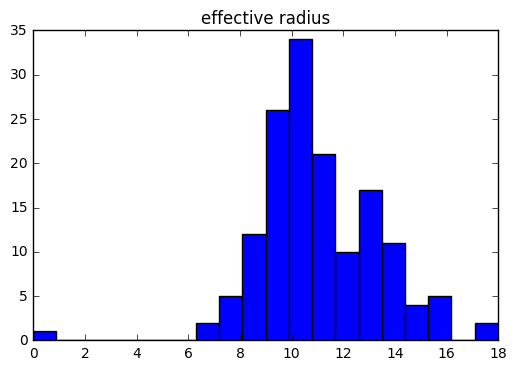

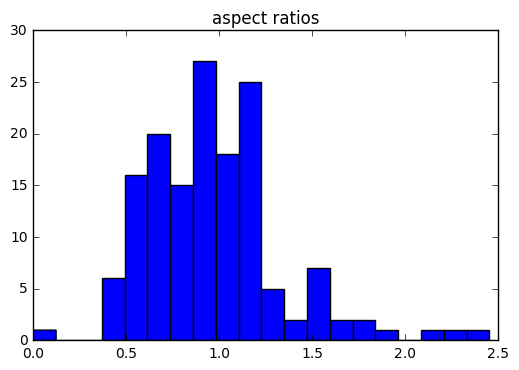

In [13]:
xc_left = -50
xc_right = -10



aspect_ratios = []
effective_radii = []

for i, oi_event in enumerate(oi_events):
    print i
    
    aspect_ratio = 0
    effective_radius = 0
    for j, ellipse in enumerate(ellipsess[i]):
        x = ellipse[1]
        y = ellipse[2]
        
        xc, yc = oi_stage.get_channel_coordinates(x, y)
        xc = oi_stage.pixels_to_meters(xc)
        
        
        
        
        if xc > xc_left and xc < xc_right:
            ax0 = ellipse[3]
            ax1 = ellipse[4]
            
            a = oi_stage.pixels_to_meters(ax0)
            b = oi_stage.pixels_to_meters(ax1)
            
            aspect_ratio = a/b
            effective_radius = np.sqrt(a*b)
            
            
            #plt.imshow(oi_vid.get_frame(oi_event._detections[ellipse[0]]._tf), cmap = 'gray', origin = 'lower')
            #plt.show()
            
            
            
            
            break
            
    if np.isnan(aspect_ratio):
        aspect_ratio = 0
    if np.isnan(effective_radius):
        effective_radius = 0
            
    aspect_ratios.append(aspect_ratio)
    effective_radii.append(effective_radius)
            
            
plt.hist(effective_radii, bins = 20)
plt.title('effective radius')
plt.show()
            
plt.hist(aspect_ratios, bins = 20)
plt.title('aspect ratios')
plt.show()      

## Filter size

In [18]:
radius_min = 5
radius_max = 12

filtering_steps.append(['effective radius filtering', radius_min, radius_max])

keep_indices_radius = [i for i in range(len(effective_radii)) if ((effective_radii[i] > radius_min) and (effective_radii[i] < radius_max))]

print(keep_indices_radius)

print ('effective radius filtering ' + str(len(oi_events) - len(keep_indices_radius)) + '/' + str(len(oi_events)))

[0, 1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 15, 16, 18, 21, 24, 26, 27, 28, 29, 30, 31, 34, 35, 38, 39, 42, 44, 46, 47, 48, 49, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 66, 67, 68, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 89, 91, 92, 93, 95, 97, 99, 100, 102, 103, 104, 105, 106, 107, 108, 109, 110, 112, 114, 115, 116, 117, 119, 120, 122, 123, 125, 126, 127, 128, 129, 130, 131, 132, 134, 135, 138, 139, 140, 146, 147, 148]
effective radius filtering 48/150


In [18]:
oi_index = 142
print effective_radii[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

17.9838400215


### Filter aspect ratio

In [19]:
aspect_min = 0.7 
aspect_max = 1.5

filtering_steps.append(['aspect_ratio_filtering min max', aspect_min, aspect_max])

keep_indices_aspect = [i for i in range(len(aspect_ratios)) if ((aspect_ratios[i] > aspect_min) and (aspect_ratios[i] < aspect_max))]

print(keep_indices_aspect)

print ('aspect ratio filtering ' + str(len(oi_events) - len(keep_indices_aspect)) + '/' + str(len(oi_events)))

[0, 1, 2, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 16, 18, 21, 24, 26, 27, 28, 29, 30, 31, 34, 35, 39, 41, 42, 43, 44, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 60, 61, 63, 66, 67, 68, 69, 71, 74, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 87, 88, 89, 91, 92, 93, 95, 96, 97, 98, 99, 100, 103, 104, 105, 106, 107, 108, 109, 110, 114, 115, 116, 117, 118, 120, 122, 123, 127, 128, 129, 130, 131, 132, 135, 137, 138, 139, 143, 145, 147]
aspect ratio filtering 49/150


In [20]:
oi_index = 139
print aspect_ratios[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

0.826102817577


### y-based filtering

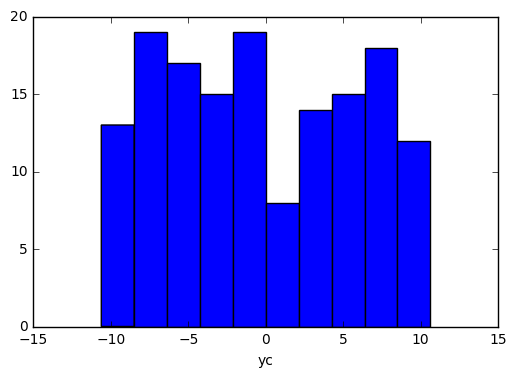

In [22]:
# Central cavity y-based filtering

yc_middles = []

for i, oi_event in enumerate(oi_events):
    
    
    xs = [ellipse[1] for ellipse in ellipsess[i]]
    ys = [ellipse[2] for ellipse in ellipsess[i]]
    
    
    xcs, ycs = oi_stage.get_channel_coordinates(xs, ys)
    xcs = oi_stage.pixels_to_meters(xcs)
    ycs = oi_stage.pixels_to_meters(ycs)
    
    
    is_interp = scipy.interpolate.interp1d(xcs, range(len(xcs)))
    
    
    i_middle = int(is_interp(oi_stage._length_microns/2.))
    
    
    yc_middles.append(ycs[i_middle])
    
    
    
    
# Apply offset to y so centered at 0
offset = -(np.max(yc_middles) - np.abs(np.min(yc_middles)))/2.
yc_middles = np.array(yc_middles)
yc_middles = yc_middles + offset


# Plot hist of all ys
plt.hist(yc_middles)
plt.xlabel('yc')
plt.show()



In [25]:
yc_threshold = 5
filtering_steps.append(['yc cavity threshold', yc_threshold])

keep_indices_y = np.where(np.abs(yc_middles) <= yc_threshold)[0]

print keep_indices_y
print 'length before', len(oi_events), 'length after', len(keep_indices_y)

[  0   9  12  13  18  20  21  22  23  24  27  28  32  37  44  45  46  48
  51  52  54  57  58  61  63  65  66  67  68  69  71  74  75  78  79  82
  83  84  86  87  88  91  93  96  98  99 100 103 104 105 107 108 109 110
 113 115 117 118 124 125 130 138 139 140 142 147]
length before 150 length after 66


In [26]:
oi_index = 8
print yc_middles[oi_index]
reload(oi_file)
plt.close()
HTML(oi_file.make_animation(oi_vid, oi_events[oi_index]._detections[0]._tf, oi_events[oi_index]._detections[-1]._tf).to_html5_video())

-6.08752844778


## Manual filtering

In [27]:
manual_remove_indices = []

filtering_steps.append(['manual removal (num events manually removed)', len(manual_remove_indices)])

keep_indices_manual = [i for i in range(len(oi_events)) if i not in manual_remove_indices]

## Filtering step

In [28]:
keep_indices = [i for i in range(len(oi_events)) if ((i in keep_indices_radius)\
                                                     and (i in keep_indices_aspect)\
                                                     and (i in keep_indices_y)\
                                                    and (i in keep_indices_manual))]


print(keep_indices)
print('filtering ' + str(len(oi_events) - len(keep_indices)) + ' out of ' + str(len(oi_events)) + ' events')

[0, 9, 12, 18, 21, 24, 27, 28, 44, 46, 48, 52, 54, 57, 58, 61, 63, 66, 67, 68, 71, 74, 75, 78, 79, 83, 84, 91, 93, 99, 100, 103, 104, 105, 107, 108, 109, 110, 115, 117, 130, 138, 139, 147]
filtering 106 out of 150 events


In [29]:
oi_events_filtered = [oi_events[i] for i in keep_indices]

# Save

### Save filtering parameters

In [30]:
output_file_path = '../data/' + date + particle + channel + 'filter_parameters_' + file_index
print output_file_path


with open(output_file_path, 'w') as file_handle:
    file_writer = csv.writer(file_handle, delimiter = '\t')
    
    
    # Write filtering steps
    for filtering_step in filtering_steps:
        print filtering_step
        file_writer.writerow(filtering_step)

../data/7-17-2017/293-T/15-30-15_1/filter_parameters_0
['effective radius filtering', 5, 12]
['aspect_ratio_filtering min max', 0.7, 1.5]
['aspect_ratio_filtering min max', 0.7, 1.5]
['effective radius filtering', 5, 12]
['effective radius filtering', 5, 12]
['aspect_ratio_filtering min max', 0.7, 1.5]
['yc cavity threshold', 5]
['yc cavity threshold', 5]
['manual removal (num events manually removed)', 0]


### Save filtered events

In [33]:
oi_events_output_file_path = oi_events_file_path.replace('.json', '_filtered.json')
oi_file.save_oi_events_json(oi_events_output_file_path, oi_events_filtered)